# Resume–Job Matching (Relevance Ranking)

CAS2105: Mini AI Pipeline Project

---


Mong Diem Quynh (2022148019)


In [1]:

# Core
import random
import numpy as np
import pandas as pd

# Embeddings
from sentence_transformers import SentenceTransformer

# Similarity & metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## Dataset
Synthetic resume–job pairs (150 samples).

In [2]:

skills = [
    "Python", "Java", "machine learning", "data analysis", "NLP", "SQL",
    "React", "Docker", "AWS", "PyTorch", "TensorFlow", "Django"
]

roles = [
    "machine learning engineer",
    "backend developer",
    "frontend developer",
    "data scientist",
    "software engineer"
]

data = []

for _ in range(150):
    resume_skills = random.sample(skills, k=4)
    job_skills = random.sample(skills, k=4)

    resume = f"Experienced professional skilled in {', '.join(resume_skills)}."
    job = f"Looking for a {random.choice(roles)} with experience in {', '.join(job_skills)}."

    label = int(len(set(resume_skills) & set(job_skills)) >= 2)

    data.append({
        "resume": resume,
        "job": job,
        "label": label
    })

df = pd.DataFrame(data)
df.head()


,resume,job,label
0,Experienced professional skilled in TensorFlow...,Looking for a software engineer with experienc...,0
1,"Experienced professional skilled in Java, PyTo...",Looking for a software engineer with experienc...,1
2,"Experienced professional skilled in PyTorch, P...",Looking for a backend developer with experienc...,0
3,"Experienced professional skilled in Docker, Py...",Looking for a backend developer with experienc...,0
4,Experienced professional skilled in data analy...,Looking for a software engineer with experienc...,1


## Train / Test Split

In [3]:

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)


## Naïve Baseline: Keyword Overlap

In [4]:

def keyword_overlap(resume, job):
    r_words = set(resume.lower().split())
    j_words = set(job.lower().split())
    return len(r_words & j_words)

train_df["baseline_score"] = train_df.apply(
    lambda x: keyword_overlap(x["resume"], x["job"]), axis=1
)

baseline_threshold = train_df["baseline_score"].median()

test_df["baseline_score"] = test_df.apply(
    lambda x: keyword_overlap(x["resume"], x["job"]), axis=1
)

test_df["baseline_pred"] = (test_df["baseline_score"] >= baseline_threshold).astype(int)

p, r, f, _ = precision_recall_fscore_support(
    test_df["label"], test_df["baseline_pred"], average="binary"
)


## AI Pipelines: Two Sentence Embedding Models

In [5]:

model_mini = SentenceTransformer("all-MiniLM-L6-v2")
model_mpnet = SentenceTransformer("all-mpnet-base-v2")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:

# MiniLM
train_res_mini = model_mini.encode(train_df["resume"].tolist(), convert_to_tensor=True)
train_job_mini = model_mini.encode(train_df["job"].tolist(), convert_to_tensor=True)

train_sim_mini = cosine_similarity(
    train_res_mini.cpu().numpy(),
    train_job_mini.cpu().numpy()
).diagonal()

mini_threshold = np.median(train_sim_mini)

test_res_mini = model_mini.encode(test_df["resume"].tolist(), convert_to_tensor=True)
test_job_mini = model_mini.encode(test_df["job"].tolist(), convert_to_tensor=True)

test_sim_mini = cosine_similarity(
    test_res_mini.cpu().numpy(),
    test_job_mini.cpu().numpy()
).diagonal()

test_df["mini_pred"] = (test_sim_mini >= mini_threshold).astype(int)

p2, r2, f2, _ = precision_recall_fscore_support(
    test_df["label"], test_df["mini_pred"], average="binary"
)


In [7]:

# MPNet
train_res_mp = model_mpnet.encode(train_df["resume"].tolist(), convert_to_tensor=True)
train_job_mp = model_mpnet.encode(train_df["job"].tolist(), convert_to_tensor=True)

train_sim_mp = cosine_similarity(
    train_res_mp.cpu().numpy(),
    train_job_mp.cpu().numpy()
).diagonal()

mp_threshold = np.median(train_sim_mp)

test_res_mp = model_mpnet.encode(test_df["resume"].tolist(), convert_to_tensor=True)
test_job_mp = model_mpnet.encode(test_df["job"].tolist(), convert_to_tensor=True)

test_sim_mp = cosine_similarity(
    test_res_mp.cpu().numpy(),
    test_job_mp.cpu().numpy()
).diagonal()

test_df["mpnet_pred"] = (test_sim_mp >= mp_threshold).astype(int)

p3, r3, f3, _ = precision_recall_fscore_support(
    test_df["label"], test_df["mpnet_pred"], average="binary"
)


## Results Summary

In [8]:

results = pd.DataFrame({
    "Method": ["Keyword Baseline", "MiniLM Pipeline", "MPNet Pipeline"],
    "Precision": [p, p2, p3],
    "Recall": [r, r2, r3],
    "F1": [f, f2, f3]
})

results


,Method,Precision,Recall,F1
0,Keyword Baseline,0.565217,1.000000,0.722222
1,MiniLM Pipeline,0.625000,0.769231,0.689655
2,MPNet Pipeline,0.647059,0.846154,0.733333


## Visualization

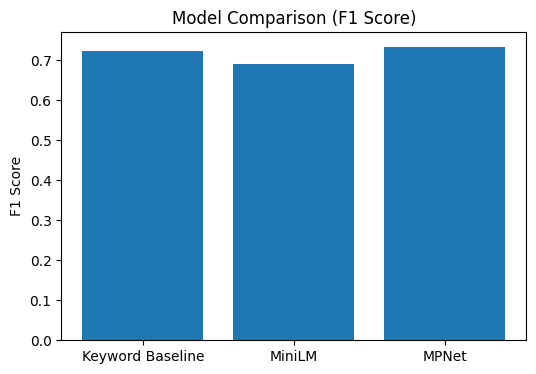

In [9]:

methods = ["Keyword Baseline", "MiniLM", "MPNet"]
f1_scores = [f, f2, f3]

plt.figure(figsize=(6,4))
plt.bar(methods, f1_scores)
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1 Score)")
plt.show()


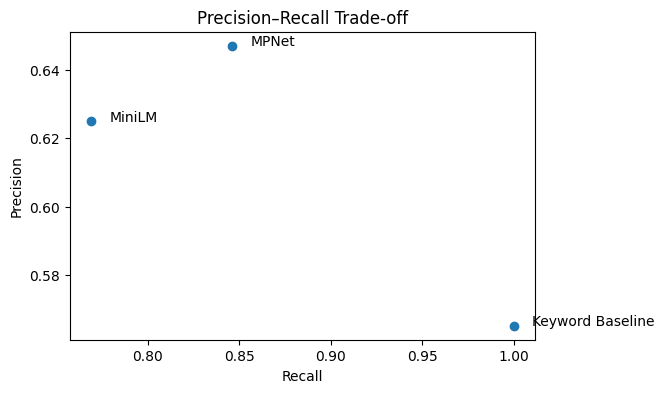

In [10]:

precision = [p, p2, p3]
recall = [r, r2, r3]

plt.figure(figsize=(6,4))
plt.scatter(recall, precision)

for i, m in enumerate(methods):
    plt.text(recall[i]+0.01, precision[i], m)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off")
plt.show()



## Conclusion

Comparing two pre-trained sentence embedding models shows a trade-off between lightweight and higher-capacity representations. While the keyword baseline achieves high recall, embedding-based pipelines provide more selective and semantically meaningful matching.
